# Lab 2: Cats vs Dogs

**Deadline**: May 28, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1uOQufriNK_sThr5j_3CKjDv2hPAZ44EZ

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms



## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

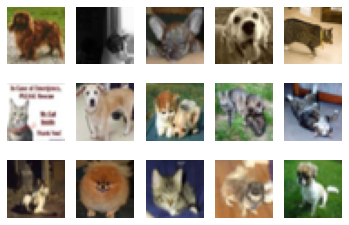

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

# Ans: The output is 15 images of cats or dogs. The images seem a bit blurry...

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
# So the function takes the target classes of cats and dogs, and produces a testing, training, and validation set. 

# To complete this, we use the code in part a:

k = 0
for images, labels in train_loader:  #change from "train_loader" to val_loader to test_loader to find the size of the sets
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5

    k += 1

print("The size of the training set is", k)

a = 0
for images, labels in val_loader:  #change from "train_loader" to val_loader to test_loader to find the size of the sets
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5

    a += 1

print("The size of the validation set is:", a)

b = 0
for images, labels in test_loader:  #change from "train_loader" to val_loader to test_loader to find the size of the sets
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5

    b += 1

print("The size of the test set is:", b)

The size of the training set is 8000
The size of the validation set is: 2000
The size of the test set is: 2000


### Part (c) -- 3pt

**Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?**

When we first train the model, we don't know how well the hyperparameters work with the current model. These hyperparameters include: the number of training iterations, the number of hidden units, the number of layers, the types of activation functions used, and the learning rate. 

After the first time training the model, we get a "base-line of comparison" for the training and validation accuracy. By using the validation set as the "test" set in this instance and the validation accuracy as the criteria, we can adjust the hyperparameters to improve the model accuracy relative to the baseline. 

Since the validation set is different than what the model learned from, there is less risk of overfitting the model. If we judge the performance of our model solely by using the training set loss/error, we will be overfitting to the training set by changing those hyperparameters, which decreases the testing accuracy for when a new testing set with different images is implemented. In the latter instance, the hyperparameters would allow the model to fit exactly with the training set such that when a new images is presented that is not part of the training set, the model would do very poorly. 

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)  #seems to be a 2 layer nn

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print("small", param.shape)

for param in large_net.parameters():
    print("large", param.shape)

# Ans: It seems that there are 5*3*3*3 + 5 + 1* 245 + 1 parameters in small_net and 5*3*5*5 + 5 + 10*5*5*5 + 10 + 32 * 250 + 32 + 32 + 1 parameters in large_net.
# so 386 in small_net and 9705 parameters in large_net.

small torch.Size([5, 3, 3, 3])
small torch.Size([5])
small torch.Size([1, 245])
small torch.Size([1])
large torch.Size([5, 3, 5, 5])
large torch.Size([5])
large torch.Size([10, 5, 5, 5])
large torch.Size([10])
large torch.Size([32, 250])
large torch.Size([32])
large torch.Size([1, 32])
large torch.Size([1])


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/err accuracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)                         #net is small_net class or big_net class
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())            # while error is the number of images labelled incorrectly
            total_train_loss += loss.item()               # loss is the error occuring during the training process used to calculate the gradient in making the model more accurate
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)

        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    return model_path




```
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

```



### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
# The default values are batch_size=64, learning_rate=0.01, num_epochs=30. 

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.



```
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
```
I think the difference between small_net and large_net is just their architecture/complexity, so running either would provide the same files saved. However, the hyperparameters that optimize their testing accuracy would be different due to their difference in complexity. 

Running train_net with small_net as argument produces 4 separate files that will be written to the disk. These files hold information, in the format of csv,  corresponding to the training error, training loss, validation error, and validation loss produced by the small_net model. For each of the files saved, there would be 5 elements/values separated by commas, one from each epoch. The file names would be as follows:



*   "model_small_bs64_lr0.01_epoch0_train_err.csv"
*   "model_small_bs64_lr0.01_epoch0_train_loss.csv"
*   "model_small_bs64_lr0.01_epoch0_val_err.csv"
*   "model_small_bs64_lr0.01_epoch0_val_loss.csv"










### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
small = train_net(small_net,batch_size=64, learning_rate=0.01, num_epochs=30)
large = train_net(large_net,batch_size=64, learning_rate=0.01, num_epochs=30)
print("small address:", small, "large address:", large)

Files already downloaded and verified
Files already downloaded and verified


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch 1: Train err: 0.42725, Train loss: 0.6728010077476502 |Validation err: 0.38, Validation loss: 0.6606546305119991
Epoch 2: Train err: 0.37275, Train loss: 0.6493331818580628 |Validation err: 0.3845, Validation loss: 0.6602172050625086
Epoch 3: Train err: 0.354125, Train loss: 0.6344249362945557 |Validation err: 0.3515, Validation loss: 0.6250083986669779
Epoch 4: Train err: 0.340875, Train loss: 0.6196128330230712 |Validation err: 0.3545, Validation loss: 0.6277146898210049
Epoch 5: Train err: 0.33625, Train loss: 0.6092757558822632 |Validation err: 0.3315, Validation loss: 0.6102728340774775
Epoch 6: Train err: 0.32025, Train loss: 0.5975090363025666 |Validation err: 0.332, Validation loss: 0.605001725256443
Epoch 7: Train err: 0.3165, Train loss: 0.5875691857337951 |Validation err: 0.3235, Validation loss: 0.5975000336766243
Epoch 8: Train err: 0.30125, Train loss: 0.5764181663990021 |Validation err: 0.3155, Validation loss: 0.5880485195666552
Epoch 9: Train err: 0.300625, Train

While small_net took around 92.29 seconds to train, large_net spent 103.52 seconds to train. This makes sense as large_net has way more parameters and weights to optimize than small_net does, so more iterations for large_net resulting in higher processing times.


I believe large_net took longer to train because large_net seems to be a multi-layer convoluted neural network while small_net has only one layer. Having more layers means more neural pathways and weight adjustments. For cnns' this means more filters are applied and more feature maps produced, which takes time to generate. In other words, more brain power is required to generate the neural network and thus, more time is needed. 

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.



I added a return line to the train_net function:

```
return model_path
```
So when I called the function, the name was saved to the variable:

```
small = train_net(small_net)
large = train_net(large_net)
print("small address:", small, "large address:", large)
```




For the small_net:


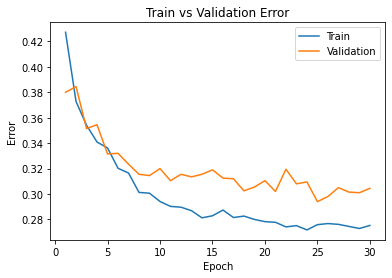

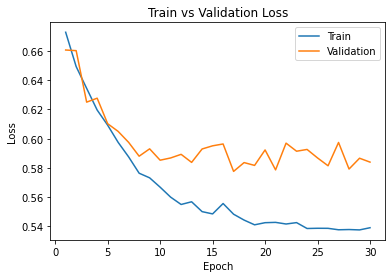

For the large_net:


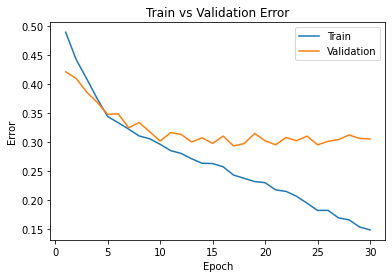

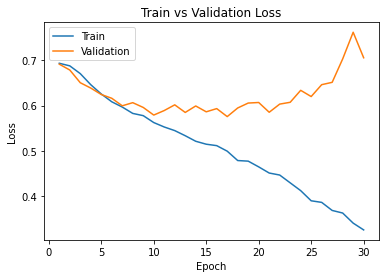

In [ ]:
print("For the small_net:")
plot_training_curve(small)
print("For the large_net:")
plot_training_curve(large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

When a model is underfit, it will have high training and validation errors. When a model is overfit, it will have extremely low training errors but a high validation error. Using this, let's analyze the graphs. 

Let's start by looking at small_net. After 30 epoches, the training error decreased by an estimated 0.14 and the validation error decreased by 0.05. This might be a slight underfit as after 30 epoches, both training and validation errors were still quite large and validation was not getting any more accurate. However, the validation error decreased to a lowest of around 0.2865, which is very close to the 0.3 from large_net. Thus, I'd say this model is doing better than large_net as of now.

Looking at large_net, after 30 epoches, the training error decreased to a very low value of 0.15. However, the validation error only decreases for the first 15 epoches, then it levels out. I think after 15 epoches, large_net may be overfitting to the data, as training error decreases dramatically but validation error remains high. 

**Personal note:** As large_net has a more complex architecture, it has the capacity to overfit as it's able to fit higher order models. The dangers of overfitting is that the model become so adept to detecting training data trends that when given new data, it will do more poorly. 

Comparing the curves for both training errors, small_net seems to be more noisy and the training curve for large_net is steeper than small_net, meaning it's better able to fit to the training data. 

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.



```
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
```
** Note the default hyperparameter values above created a time of 103.52 seconds for large_net to process. **


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

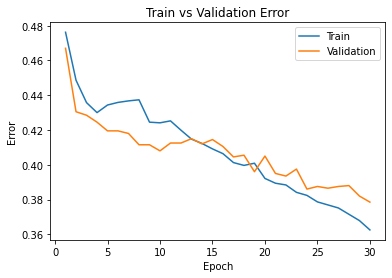

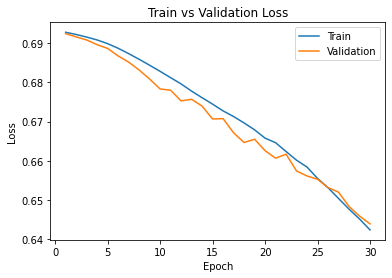

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net1 = LargeNet()   #large_net now holds the class

aa = train_net(large_net1, batch_size = 64, learning_rate = 0.001, num_epochs = 30)

plot_training_curve(aa)

With no other hyperparameters changed than the learning rate of 0.001, the model took 103.51 seconds to run. Timewise, I'd say its about the same as the default model of comparison (103.52 seconds).

However, lowering the learning rate to 0.001 results in the model being greatly underfit with 30 epoches. Whereas before, the training error was able to decrease by 0.3 after 30 epoches, now it only decreased by a max of 0.12. This is an underfit as both errors are greater than 35%, which is higher compared to the default model.  

I believe a learning rate of 0.001 is too small in the sense that we're moving too slowly in a local minimum, making it take longer to find the minimum using gradient descent. More processing power, time, and epoches is required to optimize weights. Moreover, we are stuck in a local minimum and cannot find a more optimal adjacent local minimum due to the small learning rate trapping us during gradient descent. 

I think that changing the learning rate is on par to how large each change in weight is. If the weight is changed by an amount too large every time, you overshoot the optimal weight, whereas if its too small, the weight is changed too small each iteration and you need more iterations to reach optimal value for a more accurate model. 

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

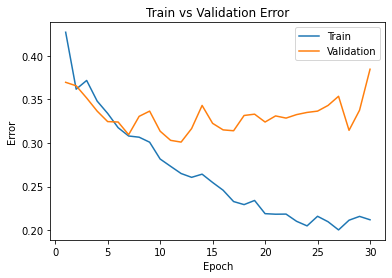

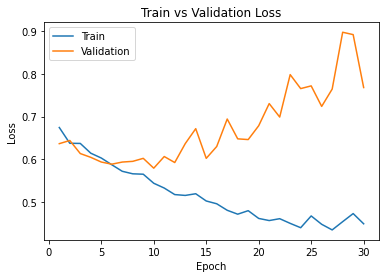

In [ ]:
large_net2 = LargeNet()
bb= train_net(large_net2, batch_size = 64, learning_rate = 0.1, num_epochs = 30)

plot_training_curve(bb)

With a sole change in learning rate to 0.1, our time elapsed was 102.27 seconds; there is no significant time difference with the default value of 103.52 seconds.

In respect to the curves, they seem more noisy, indicating the learning rate size might be too large (as defined in lecture). This large learning rate is detrimental to the learning process as validation error is clearly increasing after 10 epoches.

Increasing the learning rate allowed us to find a local minimum at epoch 12 with Validation err: 0.301. However, beyond epoch 12, the training error decreases while the validation error increases. I see this as an overfit. We're learning so much better in fitting the model to the training data with a large learning rate that we overfitted.

Thus, I conclude that changing the learing rate is on par to how large each change in weight is per iteration. If the weight is changed by an amount too large every time, you learn to fit to the training data too quickly leading to overfit, whereas if its too small, the weight is changed too small each iteration and you need more iterations to train the model. 

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

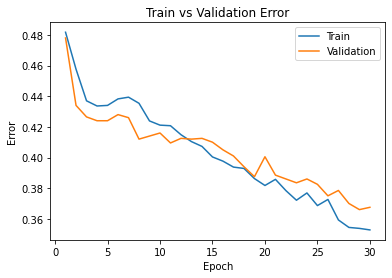

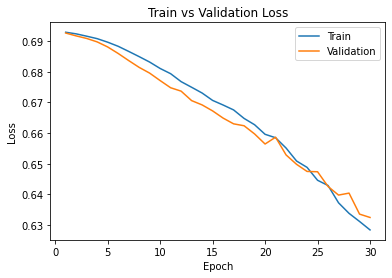

In [ ]:
large_net3 = LargeNet()

cc = train_net(large_net3, batch_size = 512, learning_rate = 0.01, num_epochs = 30)

plot_training_curve(cc)

With a larger batch size, the time is 91.39 seconds, which is much quicker than before. This is because we're covering more data every iteration; we making less iterations per epoch.

Increasing batch size seems to have underfit the model, as both errors are quite high (greater than 0.35). This makes sense as there are less iterations to readjust the weights for optimization. 

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

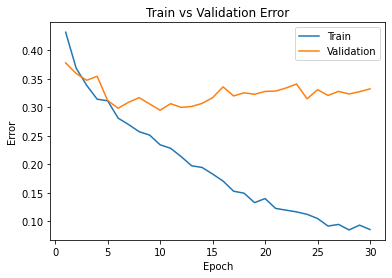

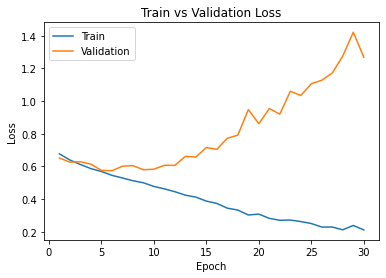

In [ ]:
large_net4 = LargeNet()

dd = train_net(large_net4, batch_size = 16, learning_rate = 0.01, num_epochs = 30)

plot_training_curve(dd)

Decreasing the batch size increases the amount of time taken to train the model dramatically to 144.61 seconds. This is because the smaller the batch size, the more iterations you must run to complete each epoch. 

Although this takes more time, it's worth it in the sense that decreasing the batch size dramatically increases training accuracy, as the training error reached an all time low of 0.10. I think this is because you're exposing the model to more data and more iterations, allowing the model to increase the amount of times parameters are adjusted. 

However, the validation error shows a slight increase after 10 epoches, meaning we're beginning to overfit the model.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.



The hardest part was choosing the network type, as both models achieved similar validation accuracy after 30 epoches. Since the outcome is either a cat or a dog and the images are either a cat or dog, I see this as a binary classification problem, which could be modelled as a linearly separated problem. I decided to test small_net because of this. Moreover, I think large_net is overfitting and small_net is doing better, as it achieved a lower error than large_net. 

We see that a large batch_size leads to underfitting and a very small batch_size leads to overfitting. However, those were the trends with large_net, a more complex architecture. Small_net has less layers and is simpler, so I don't think it will be able to overfit with a smaller batch_size and more iterations. 

For learning rate, I will leave it as 0.01, as we haven't tested learning rate yet with small_net and the optimal learning rate is different for different architectures. 

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.393, Train loss: 0.6558605691194535 |Validation err: 0.341, Validation loss: 0.6208924725055694
Epoch 2: Train err: 0.32775, Train loss: 0.610596919953823 |Validation err: 0.325, Validation loss: 0.6023299565315247
Epoch 3: Train err: 0.30675, Train loss: 0.5865861209630966 |Validation err: 0.3135, Validation loss: 0.5955414061546326
Epoch 4: Train err: 0.30525, Train loss: 0.5784442209005356 |Validation err: 0.3165, Validation loss: 0.6007771611213684
Epoch 5: Train err: 0.297625, Train loss: 0.5797662944197655 |Validation err: 0.3095, Validation loss: 0.5931810874938965
Epoch 6: Train err: 0.297625, Train loss: 0.5723144788742065 |Validation err: 0.3145, Validation loss: 0.6022099251747132
Epoch 7: Train err: 0.297375, Train loss: 0.5674350845217705 |Validation err: 0.32, Validation loss: 0.6051573741436005
Epoch 8: Train err: 0.29575, Train loss: 0.567819562971592 |Validation err: 0.296

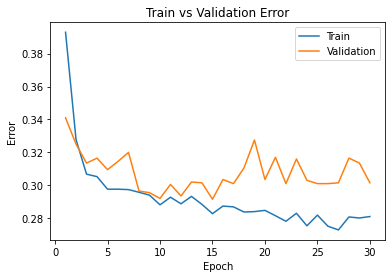

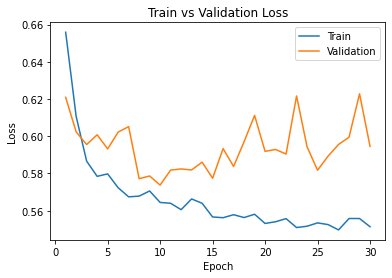

In [ ]:
small_net1 = SmallNet()

try0 = train_net(small_net1, batch_size = 16, learning_rate = 0.01, num_epochs = 30)

plot_training_curve(try0)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

The batch size might have been too small as there seems to be an overfit after 10 epoches, where validation error increases as training error decreases. Thus, I will increase the batch size to 120, which is an arbitrary number larger than 16 and 64 but not too large like 512. 

I will continue to use small_net because validation error is at a record low: Epoch 15: Train err: 0.28275, Train loss: 0.556617862701416 |Validation err: 0.2915. So the model is more accurate for this training set than large_net. 

In previous sections, I determined a large learning rate increases the likelihood of overfitting and a small learning rate is too slow for 30 epochs. As a result, I will change the learning rate to 0.009. However, learning rate is a dice roll with different architectures; I will need to try multiple validation sessions to optimize learning_rate. 

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.453875, Train loss: 0.6886639870814423 |Validation err: 0.4345, Validation loss: 0.6816189534523908
Epoch 2: Train err: 0.4185, Train loss: 0.6759939193725586 |Validation err: 0.381, Validation loss: 0.6676828756051905
Epoch 3: Train err: 0.3825, Train loss: 0.659350231512269 |Validation err: 0.364, Validation loss: 0.6511344103252187
Epoch 4: Train err: 0.36525, Train loss: 0.6424606406866614 |Validation err: 0.3545, Validation loss: 0.6368621342322406
Epoch 5: Train err: 0.348125, Train loss: 0.6264782031970237 |Validation err: 0.3465, Validation loss: 0.628253295141108
Epoch 6: Train err: 0.33625, Train loss: 0.6137025783311075 |Validation err: 0.342, Validation loss: 0.6198453552582684
Epoch 7: Train err: 0.32775, Train loss: 0.6071516844763685 |Validation err: 0.342, Validation loss: 0.6169907696106854
Epoch 8: Train err: 0.3185, Train loss: 0.5981736734731874 |Validation err: 0.334, 

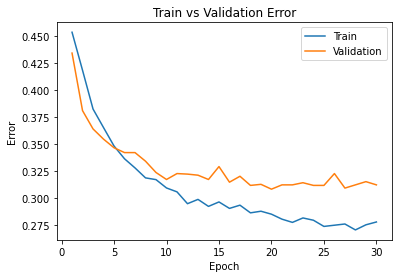

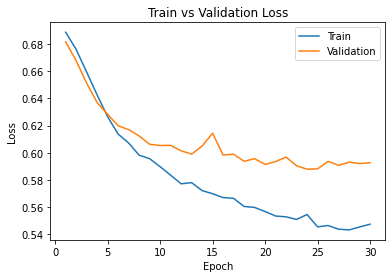

In [ ]:
small_net2 = SmallNet()
try0 = train_net(small_net2, batch_size = 120, learning_rate = 0.009, num_epochs = 30)

plot_training_curve(try0)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.





---


Epoch 15: Train err: 0.28275, Train loss: 0.556617862701416 |Validation err: 0.2915, Validation loss: 0.5774498550891877

With batch_size 16, learning rate 0.01, and epoch 30.


In [ ]:
small_net1 = SmallNet()
model_path = get_model_name(small_net1.name, batch_size=16, learning_rate=0.01, epoch=14)   #Idk why my epoch index is from 0 to 29, so I chose 14 to represent epoch = 15
state = torch.load(model_path)
small_net1.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

I was able to obtain:
Epoch 15: Train err: 0.28275, Train loss: 0.556617862701416 |Validation err: 0.2915, Validation loss: 0.5774498550891877


---



In the process where I use the validation dataset to optimize our hyperparameters, the validation accuracy is essentially the evaluation criteria for the effectiveness of our model in the real world, or at least it is the criteria we use to take us one step closer to developing an accurate model. The latter is because by changing the hyperparameters based on the validation set, we are overfitting slightly to the validation set. Thus, the hyperparameters may perform different with the test set. 

I chose this model because this model produced by far the lowest validation error and thus the highest validation accuracy. In other words, this model currently has the most optimized hyperparameters to analyze our data. 

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.





In [ ]:
def train_net_test(net, batch_size=16, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/err accuracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    test_err = np.zeros(num_epochs)
    test_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)                         #net is small_net class or big_net class
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())            # while error is the number of images labelled incorrectly
            total_train_loss += loss.item()               # loss is the error occuring during the training process used to calculate the gradient in making the model more accurate
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        test_err[epoch], test_loss[epoch] = evaluate(net, test_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Test err: {}, Test loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   test_err[epoch],
                   test_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
 
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_test_err.csv".format(model_path), test_err)
    np.savetxt("{}_test_loss.csv".format(model_path), test_loss)
 
    return model_path

In [ ]:
small_net5 = SmallNet()
cp=train_net_test(small_net5, batch_size=16, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.393, Train loss: 0.6558605691194535 |Test err: 0.3425, Test loss: 0.6143452575206757
Epoch 2: Train err: 0.32775, Train loss: 0.610596919953823 |Test err: 0.2975, Test loss: 0.5774856667518615
Epoch 3: Train err: 0.30675, Train loss: 0.5865861209630966 |Test err: 0.3015, Test loss: 0.5739656782150269
Epoch 4: Train err: 0.30525, Train loss: 0.5784442209005356 |Test err: 0.2975, Test loss: 0.5792060186862945
Epoch 5: Train err: 0.297625, Train loss: 0.5797662944197655 |Test err: 0.3035, Test loss: 0.5771282329559326
Epoch 6: Train err: 0.297625, Train loss: 0.5723144788742065 |Test err: 0.2995, Test loss: 0.5732781200408935
Epoch 7: Train err: 0.297375, Train loss: 0.5674350845217705 |Test err: 0.3095, Test loss: 0.5820371494293213
Epoch 8: Train err: 0.29575, Train loss: 0.567819562971592 |Test err: 0.29, Test loss: 0.5588648977279663
Epoch 9: Train err: 0.294, Train loss: 0.57058719369769

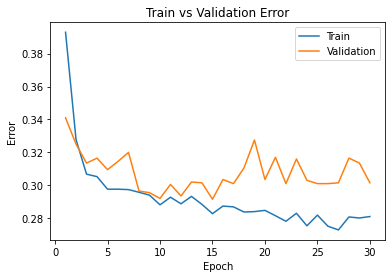

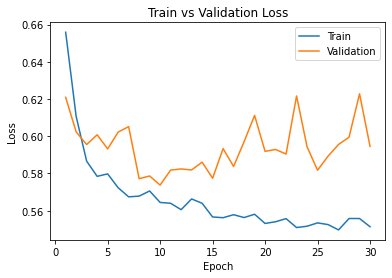

In [ ]:
plot_training_curve(cp)
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
#train_loader, val_loader, test_loader, classes = get_data_loader(
 #   target_classes=["cat", "dog"], 
  #  batch_size=64)

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

Testing: Epoch 15: Train err: 0.28275, Train loss: 0.556617862701416 |Test err: 0.288, Test loss: 0.5641616320610047

Validation: Epoch 15: Train err: 0.28275, Train loss: 0.556617862701416 |Validation err: 0.2915, Validation loss: 0.5774498550891877


---



While the lowest valiation error for small_net was 0.2915, the lowest testing error for was 0.288. This is a bit unusual as the testing error is slightly lower than the validation error. The hyperparameters should have been optimized to the validation dataset, resulting in an "overfit" to the validation set; validation error should be lower. 

The test data set is completely different and isolated such that the model has no prior experience dealing with them; the hyperparameters are not optimized to the testing set. Thus, like any new thing we encounter, we are more unsure about it and thus, the testing error should be higher than the validation error. 

This could just be luck that the testing set resembled the training data more than the validation data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We use the validation set to adjust our hyperparameters towards optimizing the weights and increasing the accuracy of the model. However, by doing so, we are also overfitting to the validation set, as we may be using the validation set multiple times to change our hyperparameters. 

Thus, a test set should be saved for the end and only used ONCE.

The test set should be used for final evaluation of how accurate our model would be out in the real world given any set of data. We only use the test data set ONCE because we want our final evaluation to be unbiased as possible. If we were to use the test set more than once, it means we used the test set to adjust our hyperparameters, meaning we had once again lowkey overfitted to the test data. 

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([5])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([5])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([3])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([3])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([3])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([5])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([3])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([3])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([3])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([3])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([3])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([5])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([5])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([5])
torch.Size([32, 32, 3])
<class 'torch.Tensor'>
tensor([5])


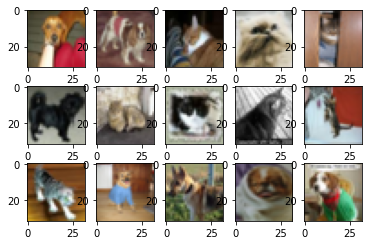

In [ ]:
##################
# Convert to grayscale:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

# Determine the torch size of the images
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    #img=rgb2gray(img)
    plt.subplot(3, 5, k+1)
    plt.axis('on')
    plt.imshow(img)
    print(img.shape)
    print(type(img))
    print(labels)

    k += 1
    if k > 14:
        break


**Imported image shape is originally 32 by 32 by 3**

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.423625, Train loss: 0.6707942414639602 |Test err: 0.382, Test loss: 0.651926552548128
Epoch 2: Train err: 0.3765, Train loss: 0.6445972661473858 |Test err: 0.369, Test loss: 0.6440417451017043
Epoch 3: Train err: 0.358, Train loss: 0.6325617219085125 |Test err: 0.3585, Test loss: 0.6392326845842249
Epoch 4: Train err: 0.34325, Train loss: 0.6208928859055932 |Test err: 0.3755, Test loss: 0.6484908636878518
Epoch 5: Train err: 0.33425, Train loss: 0.6135592683037715 |Test err: 0.3695, Test loss: 0.6475950128891889
Epoch 6: Train err: 0.321, Train loss: 0.6033995845424596 |Test err: 0.363, Test loss: 0.6424226550494924
Epoch 7: Train err: 0.313875, Train loss: 0.5920088700394133 |Test err: 0.356, Test loss: 0.6433013046489042
Epoch 8: Train err: 0.305375, Train loss: 0.5803860630562057 |Test err: 0.3655, Test loss: 0.6479753115597893
Epoch 9: Train err: 0.29675, Train loss: 0.5692370520598853

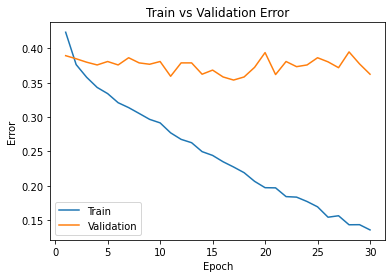

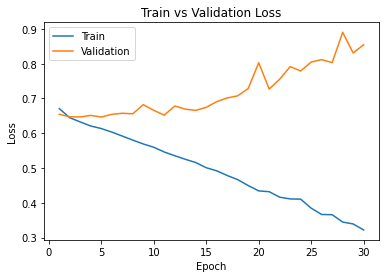

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)    # note that the output to the last layer must be 1.
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

pigeon = Pigeon()

def evaluatea(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        labels = labels.unsqueeze(1)
        loss = criterion(outputs, labels.float())
        labels = labels.squeeze(1)
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def train_neta(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/err accuracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)                         #net is small_net class or big_net class
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            labels = labels.squeeze(1)
            # Calculate the statistics
            
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())            # while error is the number of images labelled incorrectly
            total_train_loss += loss.item()               # loss is the error occuring during the training process used to calculate the gradient in making the model more accurate
            total_epoch += len(labels)
            
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluatea(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)

        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    return model_path

def train_net_testa(net, batch_size=512, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/err accuracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    test_err = np.zeros(num_epochs)
    test_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)   
            labels = labels.unsqueeze(1)                      #net is small_net class or big_net class
            loss = criterion(outputs, labels.float())
            labels = labels.squeeze(1)
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())            # while error is the number of images labelled incorrectly
            total_train_loss += loss.item()               # loss is the error occuring during the training process used to calculate the gradient in making the model more accurate
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        test_err[epoch], test_loss[epoch] = evaluatea(net, test_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Test err: {}, Test loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   test_err[epoch],
                   test_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
 
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_test_err.csv".format(model_path), test_err)
    np.savetxt("{}_test_loss.csv".format(model_path), test_loss)
 
    return model_path

cc = train_net_testa(pigeon, batch_size = 120, learning_rate = 0.009, num_epochs = 30)
plot_training_curve(cc)

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

The best I was able to achieve with the ANN was Epoch 24: Train err: 0.177125, Train loss: 0.4105702949993646 |Test err: 0.3465, Test loss: 0.7360313219182631

with cc = train_net(pigeon, batch_size = 120, learning_rate = 0.009, num_epochs = 30)

My best CNN produced the results of Epoch 15: Train err: 0.28275, Train loss: 0.556617862701416 |Test err: 0.288, Test loss: 0.5641616320610047


---



It seems the pigeon neural network architecture overfits the model to the training data much more than both convoluted networks. The testing accuracy barely improves compared to the training accuracy. Plus, there is a lot of noise. The test error was around 0.0585 greater for pigeon than small_net.

Unlike the MNIST dataset, these images of cats and dogs have not been preprocessed. A convoluted neural network would use different convoluted filters to isolate the target we want to label (so it'll help to preprocess the images) and then train the model to detect certain features important to us. 

Since the images aren't preprocessed, the pigeon neural network cannot accurately place weights to specific pixel positions and produce an accurate threshold to where it expects certain values to exist in order to classify the image. Thus, although training accuracy increases dramatically, the testing accuracy is worse than a convoluted neural network. 